In [1]:
import numpy as np

from sklearn import preprocessing
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
import pickle
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import losses
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATA_PATH = "/content/drive/My Drive"
infile = open(DATA_PATH+'/Image_data.p','rb')
X_data = pickle.load(infile)

infile = open(DATA_PATH+'/Image_label.p','rb')
y_label = pickle.load(infile)

In [0]:
# Dice metrics

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [0]:
def convertTo1D(X):
    new_X = []
    for image in X:
        im = image.flatten()
        new_X.append(im)
    return new_X

def convertTo2D(X):
    new_X = []
    for image in X:
        im = np.reshape(image,(256,256))
        new_X.append(im)
    return new_X

def minmaxscaler(X,y):
    scaler = MinMaxScaler((0,1))
    X_flat = convertTo1D(X_data)
    y_flat = convertTo1D(y_label)
    
    norm_X = scaler.fit_transform(X_flat)
    norm_y = scaler.fit_transform(y_flat)
    
    new_X = convertTo2D(norm_X)
    new_y = convertTo2D(norm_y)
    
    return new_X,new_y

In [0]:
# Creating the model

def apply_unet(pretrained_W = None, input_size = (256,256,1)):
    Inputs = Input(input_size)

    Conv1 = Conv2D(64,3, activation='relu',padding='same')(Inputs)
    Conv1 = Conv2D(64,3, activation='relu',padding='same')(Conv1)
    Pool1 = MaxPool2D(pool_size=(2,2))(Conv1)

    Conv2 = Conv2D(128,3, activation='relu',padding='same')(Pool1)
    Conv2 = Conv2D(128,3, activation='relu',padding='same')(Conv2)
    Pool2 = MaxPool2D(pool_size=(2,2))(Conv2)

    Conv3 = Conv2D(256,3, activation='relu',padding='same')(Pool2)
    Conv3 = Conv2D(256,3, activation='relu',padding='same')(Conv3)
    Pool3 = MaxPool2D(pool_size=(2,2))(Conv3)

    Conv4 = Conv2D(512,3, activation='relu',padding='same')(Pool3)
    Conv4 = Conv2D(512,3, activation='relu',padding='same')(Conv4)
    Pool4 = MaxPool2D(pool_size=(2,2))(Conv4)

    Conv5 = Conv2D(1024,3, activation='relu',padding='same')(Pool4)
    Conv5 = Conv2D(1024,3, activation='relu',padding='same')(Conv5)
    Up6 = UpSampling2D(size=(2,2))(Conv5)

    Conv6 = Conv2D(512,2, activation='relu',padding='same')(Up6)
    merge7 = concatenate([Conv4,Conv6], axis=3)

    Conv7 = Conv2D(512,2, activation='relu',padding='same')(merge7)
    Conv7 = Conv2D(512,2, activation='relu',padding='same')(Conv7)
    Up8 = UpSampling2D(size=(2,2))(Conv7)

    Conv8 = Conv2D(256,3, activation='relu', padding='same')(Up8)
    merge9 = concatenate([Conv3,Conv8], axis=3)

    Conv10 = Conv2D(256,3, activation='relu', padding='same')(merge9)
    Conv10 = Conv2D(256,3, activation='relu', padding='same')(Conv10)
    Up11 = UpSampling2D(size=(2,2))(Conv10)

    Conv12 = Conv2D(128,3, activation='relu', padding='same')(Up11)
    merge13 = concatenate([Conv2,Conv12], axis=3)

    Conv14 = Conv2D(128,3, activation='relu', padding='same')(merge13)
    Conv14 = Conv2D(128,3, activation='relu', padding='same')(Conv14)
    Up15 = UpSampling2D(size=(2,2))(Conv14)

    Conv16 = Conv2D(64,3, activation='relu', padding='same')(Up15)
    merge17 = concatenate([Conv1,Conv16], axis=3)

    Conv18 = Conv2D(64,3, activation='relu', padding='same')(merge17)
    Conv18 = Conv2D(64,3, activation='relu', padding='same')(Conv18)

    Conv19 = Conv2D(2,3,activation='relu', padding='same')(Conv18)
    Conv20 = Conv2D(1,1, activation='sigmoid')(Conv19)

    model = Model(input = Inputs, output = Conv20)

    model.compile(optimizer = Adam(1e-4), loss = [dice_loss], metrics= [dice_coef])


    model.summary()

    if pretrained_W :
        model.load_weights(pretrained_W)

    return model

In [0]:
X_data,y_label = minmaxscaler(X_data,y_label)
X_data = np.asarray(X_data)
y_label = np.asarray(y_label)

In [0]:
 x_train,x_test,y_train,y_test=train_test_split(X_data,y_label,test_size=0.1)

In [9]:
# create model 1
model1 = apply_unet()

# reshape the data and mask
train_images = x_train.reshape(-1,256,256,1)
train_label = y_train.reshape(-1,256,256,1)

# training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model1.fit(train_images,train_label, batch_size=4, epochs=10, verbose=1, validation_split=0.1, shuffle=True, callbacks=[model_checkpoint,es] )

model1.save('model1.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
test_images = x_test.reshape(-1,256,256,1)
test_label = y_test.reshape(-1,256,256)

In [0]:
def dice_coefficient(pred, target):
    smooth = 1
    m1 = pred.flatten()  # Flatten
    m2 = target.flatten()  # Flatten
    intersection = (m1 * m2).sum()

    return (2 * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [0]:
y_test_pred = model1.predict(test_images)

In [0]:
y_test_pred = y_test_pred.reshape(-1,256,256)

In [0]:
val = 0
for i in range(y_test_pred.shape[0]):
  val1 = dice_coefficient(y_test_pred[i],test_label[i])
  val = val + val1

dice_val = val/y_test_pred.shape[0]

In [15]:
print(dice_val)

0.9085243580389634


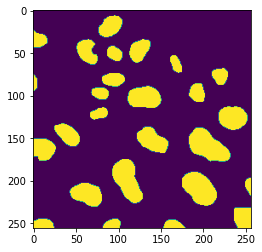

In [16]:
plt.imshow(test_label[0])

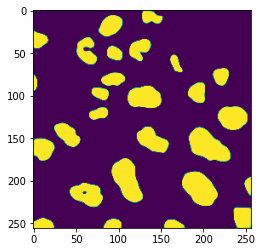

In [17]:
plt.imshow(y_test_pred[0])